In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken # A biblioteca oficial de tokenização da OpenAI
import matplotlib.pyplot as plt
import time

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Rodando no dispositivo: {device}")

Rodando no dispositivo: cpu


In [11]:
# Hiperparâmetros que vamos utilizar para o modelo BPE
block_size = 64       # Contexto (T)
batch_size = 16       # Lote (B)
max_iters = 5000      # Ciclos de treino
learning_rate = 3e-4  # Taxa menor para estabilidade com vocab grande
eval_iters = 200
n_embd = 128          # Dimensão do embedding (d_model)
n_layer = 4           # Camadas
n_head = 4            # Cabeças
dropout = 0.2

In [12]:
# Carregando os arquivos e a Tokenização BPE
files = ['dom_casmurro.txt', 'constituicao_federal.txt', 'memorias_postumas.txt'] 

print("Lendo arquivos...")
text = ""
files_found = 0
for file_name in files:
    try:
        with open(file_name, 'r', encoding='utf-8') as f:
            content = f.read()
            text += content + "\n"
            print(f" - Arquivo '{file_name}' carregado ({len(content)} caracteres).")
            files_found += 1
    except FileNotFoundError:
        print(f"ERRO: Arquivo '{file_name}' não encontrado. Pulei.")

if files_found == 0:
    raise Exception("Nenhum arquivo de texto foi encontrado! Verifique os nomes.")

print(f"Tamanho total do dataset bruto: {len(text)} caracteres")

Lendo arquivos...
 - Arquivo 'dom_casmurro.txt' carregado (399697 caracteres).
 - Arquivo 'constituicao_federal.txt' carregado (700045 caracteres).
 - Arquivo 'memorias_postumas.txt' carregado (386167 caracteres).
Tamanho total do dataset bruto: 1485912 caracteres


In [13]:
# TOKENIZAÇÃO TIKTOKEN
print("Tokenizando com GPT-2 BPE")
enc = tiktoken.get_encoding("gpt2")
encoded_data = enc.encode(text)
vocab_size = enc.n_vocab # Isso será 50257 (Padrão GPT-2)
print(f"Tamanho do Vocabulário: {vocab_size} tokens únicos")
print(f"Total de Tokens para treino: {len(encoded_data)}")

Tokenizando com GPT-2 BPE
Tamanho do Vocabulário: 50257 tokens únicos
Total de Tokens para treino: 587607


In [14]:
# Separação Treino / Validação
data = torch.tensor(encoded_data, dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [15]:
# Infraestrutura do Modelo Transformer
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   
        q = self.query(x) 
        wei = q @ k.transpose(-2, -1) * C**-0.5 
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) 
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v 
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
        
class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Anteriormente no gpt-v3 o vocab_size era 95 vocab_size agora é 50257
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        tok_emb = self.token_embedding_table(index) 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) 
        x = tok_emb + pos_emb
        x = self.blocks(x) 
        x = self.ln_f(x) 
        logits = self.lm_head(x) 

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1) 
            idx = torch.cat((idx, idx_next), dim=1) 
        return idx

In [16]:
# Execução
model = GPTLanguageModel()
m = model.to(device)
print(f"Modelo PT-BR criado com {sum(p.numel() for p in m.parameters())/1e6:.2f} M parâmetros")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_history_train = []
loss_history_val = []

print("Iniciando treinamento em Português...")
start_time = time.time()

for iter in range(max_iters):
    
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        loss_history_train.append(losses['train'])
        loss_history_val.append(losses['val'])

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

end_time = time.time()
print(f"Treinamento finalizado em {(end_time - start_time)/60:.2f} minutos.")

Modelo PT-BR criado com 13.72 M parâmetros
Iniciando treinamento em Português...
step 0: train loss 10.8588, val loss 10.8605
step 200: train loss 5.5421, val loss 6.1175
step 400: train loss 4.4195, val loss 5.3617
step 600: train loss 3.9969, val loss 5.0065
step 800: train loss 3.6847, val loss 4.7663
step 1000: train loss 3.4732, val loss 4.5881
step 1200: train loss 3.3759, val loss 4.4746
step 1400: train loss 3.2455, val loss 4.3930
step 1600: train loss 3.1440, val loss 4.2739
step 1800: train loss 3.0689, val loss 4.2599
step 2000: train loss 3.0156, val loss 4.2070
step 2200: train loss 2.9391, val loss 4.1695
step 2400: train loss 2.8602, val loss 4.1210
step 2600: train loss 2.8234, val loss 4.0576
step 2800: train loss 2.7797, val loss 4.0328
step 3000: train loss 2.7434, val loss 4.0311
step 3200: train loss 2.6950, val loss 3.9879
step 3400: train loss 2.7016, val loss 3.9729
step 3600: train loss 2.6346, val loss 3.9271
step 3800: train loss 2.5801, val loss 3.9494
step

Gráfico salvo: grafico_loss_ptbr.png


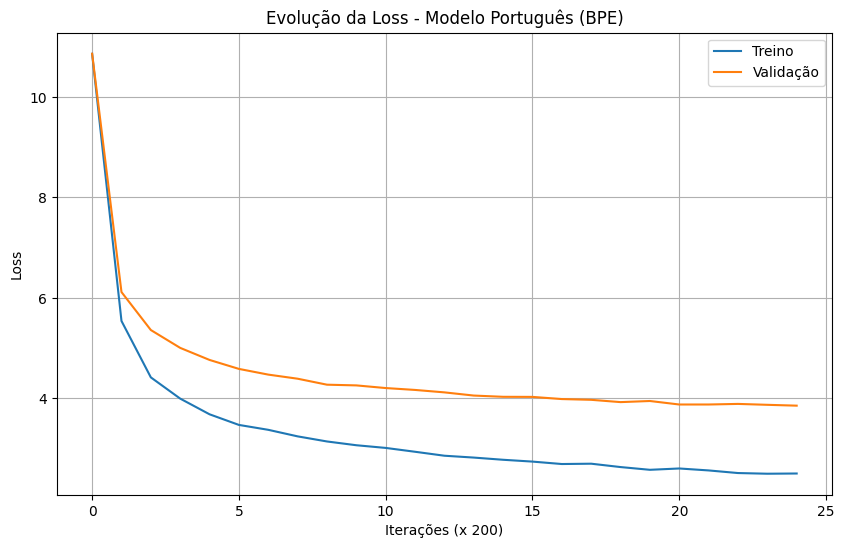

In [17]:
# Plotagem do Gráfico
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train, label='Treino')
plt.plot(loss_history_val, label='Validação')
plt.title('Evolução da Loss - Modelo Português (BPE)')
plt.xlabel(f'Iterações (x {eval_iters})')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('grafico_loss_ptbr.png')
print("Gráfico salvo: grafico_loss_ptbr.png")

In [18]:
# Geração de Texto
print("\n" + "="*30)
print("GERANDO TEXTO EM PORTUGUÊS")
print("="*30 + "\n")

model.eval()


GERANDO TEXTO EM PORTUGUÊS



GPTLanguageModel(
  (token_embedding_table): Embedding(50257, 128)
  (position_embedding_table): Embedding(64, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine

In [19]:
# Gerar texto a partir do vazio
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_ids = model.generate(context, max_new_tokens=200)

# Decode usando tiktoken
print(enc.decode(generated_ids[0].tolist()))

# Salvando
torch.save(model.state_dict(), 'gpt_ptbr_final.pth')
print("Modelo salvo como gpt_ptbr_final.pth")

! Pou Federal
Sancha os simples ao livros, tomavam asuneradas à margem logar amor
uma casa, segam da medicina. A guanto clarantes faria as mãos
constituição, des illustrei, com ellas e as rarias da morte de costumava para
affecto,, se tal chacando, educava-lhe a sua sensação dos egoista, porque
Capitú...

E lhe catalogo que exclamou repetiu-me que haa mulher então melhor-lhe
José Dias, que mereceguia dialogo, da roer em ouvir com a effeito, na praia
correr á á propria nenhardo dia as cores, com outras, e Josévindes:


Modelo salvo como gpt_ptbr_final.pth
